# Import libraries

In [49]:
import os
from helpers import parse_variables
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from helpers import parse_variables
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from helpers import parse_variables, get_risk_level, hi_gauss_blob_risk_fun, blob_risk_fun, NW_risk_fun, square_risk_fun, map_to_color, simulate_genos, calculate_true_maf_per_pop
from matplotlib.colors import LinearSegmentedColormap
import importlib.util
from models import ols_regression, manhattan_linear, gc

In [50]:
def divi(arr, effectsize):
    return [(1 / (num + 0.001)) * effectsize for num in arr]

def multi(arr, effectsize):
    return [num * effectsize for num in arr]

In [51]:
# Load genotype

In [52]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
if 'k' not in globals():
    k = int(dict['k'])
    
if 'M' not in globals():
    M = float(dict['M'])

if 'snp_noise' not in globals():
    snp_noise = 0.1
HWE = int(dict['HWE'])

nr_humans = int(dict['nr_humans'])
nr_snps = int(dict['nr_snps'])
bottleneck_nr = int(dict['bottleneck_nr'])

if 'tools' not in globals():
    tools = ['no_corr','abyss_counted', 'abyss', 'abyss_corrected', 'PCA','abyss_pca']

"""
if 'scenarios' not in globals():
    scenarios = ['snp_effect',
                 'linear_continuous',
                 'non_linear_continuous',
                 'discrete_global',
                 'discrete_localized',
                 'mix_linear_continuous',
                 'mix_non_linear_continuous',
                 'mix_discrete_global',
                 'mix_discrete_localized']
"""
if 'scenarios' not in globals():
    scenarios = ['discrete_global']
if 'very_rare_threshold_L' not in globals():
    very_rare_threshold_L = float(dict['very_rare_threshold_L'])
if 'very_rare_threshold_H' not in globals():
    very_rare_threshold_H = float(dict['very_rare_threshold_H'])
if 'rare_threshold_L' not in globals():
    rare_threshold_L = float(dict['rare_threshold_L'])
if 'rare_threshold_H' not in globals():
    rare_threshold_H = float(dict['rare_threshold_H'])
if 'common_threshold_L' not in globals():
    common_threshold_L = float(dict['common_threshold_L'])
if 'common_threshold_H' not in globals():
    common_threshold_H = float(dict['common_threshold_H'])

number_of_snps = (G*L)/2 # one loci per chromosome
number_of_individuals = c*k*k


very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/genotype/01_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/genotype/01_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/genotype/01_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

if 'to_analyze' not in globals():
    to_analyze = "complete"

if to_analyze == "complete":
    complete = pd.concat([common, rare, very_rare], axis=1)
elif to_analyze == "common":
    complete = common.copy()
    
elif to_analyze == "rare":
    complete = rare.copy()
elif to_analyze == "very_rare":
    complete = very_rare.copy()
    
geno = ((complete*2)-1)


In [53]:
# Names of the environmental risks
proto_naming_dict = {
    "no_risk": "no environmental risk",
    "NW_risk": "Smooth linear North-West environmental risk",
    "N_risk" : "Smooth linear North environmental risk",
    "as_big_blob_risk": "Localised big blob risk",
    "center_risk": "Localised big central risk",
    "big_square_risk": "big square risk",
    "square_risk" : "Tiny square risk",
    'hi_square_risk' : "Tiny square risk",
    "hi_gauss_blob_risk": "Global Gaussian Risk",
    "two_square_risk": "Two tiny risks",
    "gauss_blob_risk" : "Gaussian Risk",
    "three_square_risk": "Three localized Risks",
    "mid_mid_square_risk": "Mid square risk",
    "hi_hyperbole_risk": "Hyperbole risk",
    "sine_risk": "Sinusoidal risk"
    
}

In [54]:
existing_risks = [
    "no_risk_fun",
    "NW_risk_fun",
    "N_risk_fun",
    "blob_risk_fun",
    "center_risk_fun",
    "big_square_risk_fun",
    "square_risk_fun",
    "hi_square_risk_fun",
    "mid_square_risk_fun",
    "mid_mid_square_risk_fun",
    "mid_mid_mid_square_risk_fun",
    "big_bad_square_risk_fun",
    "big_square_risk_fun_updated",
    "big_big_square_risk_fun",
    "big_big_big_square_risk_fun",
    "two_square_risk_fun",
    "three_square_risk_fun",
    "four_square_risk_fun",
    "as_big_blob_risk_fun",
    "six_square_risk_fun",
    "gauss_blob_risk_fun",
    "hi_gauss_blob_risk_fun"
]

In [55]:
risk = "blob_risk_fun"

In [56]:
humans = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/phenotype/01_population_structure.pkl")

In [57]:
humans['pop_nr'] = humans['populations'].str.extract(r'(\d+)').astype(int)

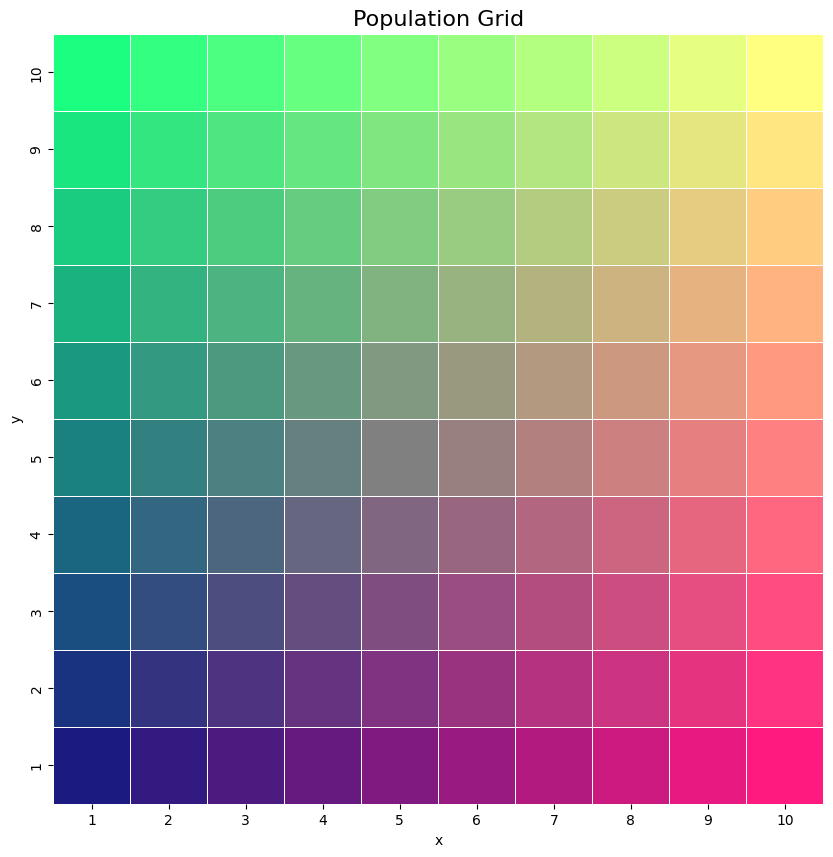

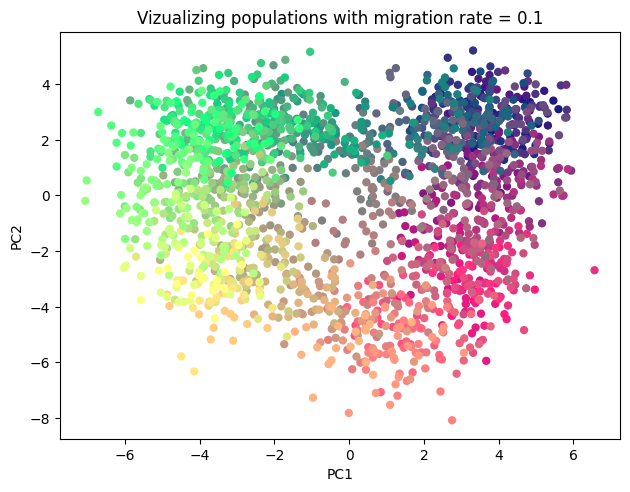

In [58]:
palette = [map_to_color(x, y, z, humans) for x, y, z in zip(humans['x'], humans['y'], humans['z'])]
df_agg = humans.groupby(['x', 'y']).agg({'pop_nr': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='pop_nr')

# Use seaborn to create the heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()
plt.close()

scaler = StandardScaler()
scaled_geno = scaler.fit_transform(geno)
n_components = max(min(geno.shape[1], 50), 4)
pca = PCA(n_components=n_components)
pc_labels_complete = [f"PC{i}" for i in range(1, n_components + 1)]
PC_geno = pca.fit_transform(scaled_geno)
PC_geno = pd.DataFrame(data=PC_geno, columns=pc_labels_complete)

PC_geno['populations'] = humans['populations']

sns.scatterplot(x='PC1', y='PC2', data=PC_geno, color=palette, linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing populations with migration rate = {M}")
plt.show()
plt.close()

<Axes: xlabel='x', ylabel='y'>

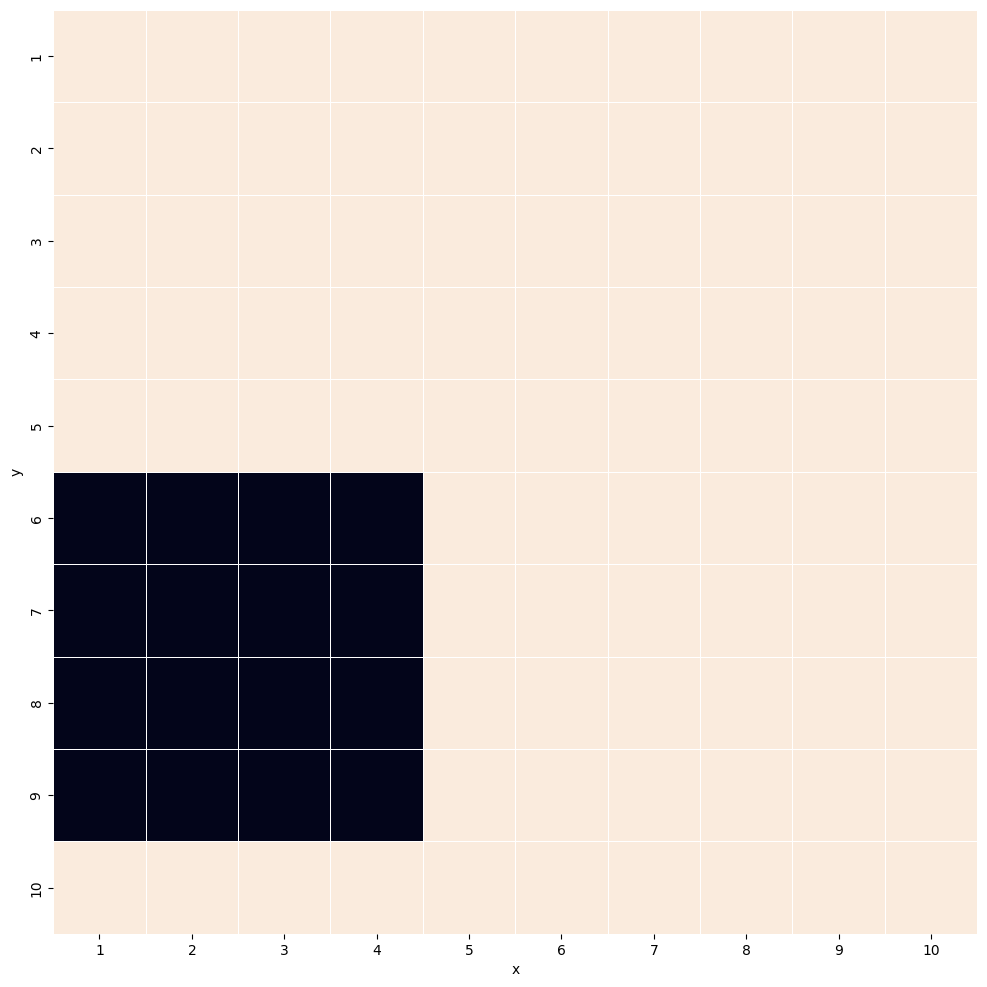

In [59]:
# Dynamically import the function based on the risk level
module_name = 'helpers'
module_spec = importlib.util.spec_from_file_location(module_name, 'helpers.py')
helpers = importlib.util.module_from_spec(module_spec)
module_spec.loader.exec_module(helpers)
risk_function = getattr(helpers, risk)
name_risk = risk.split('_fun')[0]
humans['x_temp'] = humans['x']/k
humans['y_temp'] = humans['y']/k
humans[name_risk] = list(humans.apply(lambda row: risk_function(row['x_temp'], row['y_temp']), axis=1))
humans[name_risk] = humans[name_risk].astype('float')

# Create subplots for each risk
fig, axs = plt.subplots(1, 1, figsize=(14, 12))
# Aggregate by x and y and calculate mean for each risk
df_agg = humans.groupby(['x', 'y']).agg({name_risk: 'mean'}).reset_index()
grid_df = df_agg.pivot(index='y', columns='x', values=name_risk)
sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)

In [60]:
humans

,populations,x,y,z,pop_nr,x_temp,y_temp,blob_risk
0,pop 1,1,1,0.5,1,0.1,0.1,0.0
1,pop 1,1,1,0.5,1,0.1,0.1,0.0
2,pop 1,1,1,0.5,1,0.1,0.1,0.0
3,pop 1,1,1,0.5,1,0.1,0.1,0.0
4,pop 1,1,1,0.5,1,0.1,0.1,0.0
...,...,...,...,...,...,...,...,...
1995,pop 100,10,10,0.5,100,1.0,1.0,0.0
1996,pop 100,10,10,0.5,100,1.0,1.0,0.0
1997,pop 100,10,10,0.5,100,1.0,1.0,0.0
1998,pop 100,10,10,0.5,100,1.0,1.0,0.0


In [61]:
af_values = geno.columns.str.extract(r'_AF_([\d\.]+)')[0].astype(float)
effectsize = 1
beta_values = divi(af_values, effectsize)
data = {'snp': list(geno.columns), 'Beta': beta_values}
betas = pd.DataFrame(data)

betas['maf_vals'] = af_values
betas['mafs'] = np.where(betas['maf_vals'] > 0.2, 'common',
                      np.where(betas['maf_vals'] >= 0.05, 'rare', 'very rare'))

In [62]:
# if we want all the snps to have the same effect
#betas['Beta'] = 1
#betas

In [63]:
snp_noise = 0.1

In [64]:
all_snps = list(geno.columns)
phenos_mono = []
for snp in all_snps:
    beta_value = betas.loc[betas['snp'] == snp, 'Beta'].values[0]
    phenos_mono.append(geno[snp] * beta_value)

# Converting phenos_mono list of series to DataFrame directly
phenos_mono = pd.concat(phenos_mono, axis=1)
phenos_mono.columns = geno.columns

# Add noise
n = len(phenos_mono)
for snp in list(phenos_mono.columns):
    var_effect = np.var(phenos_mono[snp])
    total_variance = var_effect / (1-snp_noise)
    var_noise = total_variance - var_effect
    sd_noise = np.sqrt(var_noise)
    # Generate phenotype with noise
    phenos_mono[snp] = phenos_mono[snp] + np.random.normal(0, sd_noise, n)

# Test Abyss

In [65]:
# load abyss

In [66]:
pq_file = [f for f in os.listdir(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/genotype/") if f.startswith("estimated_2pqs")][0]
p2_file = [f for f in os.listdir(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/genotype/") if f.startswith("estimated_p2s")][0]
q2_file = [f for f in os.listdir(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/genotype/") if f.startswith("estimated_q2s")][0]

In [67]:
esti_p2 = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/genotype/{p2_file}")
esti_twopq = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/genotype/{pq_file}")
esti_q2 = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/genotype/{q2_file}")

In [68]:
# laod true MAFs

In [69]:
true_p2s = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/genotype/02_true_p2_via_true_pop.pkl")
true_twopqs = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/genotype/02_true_twopq_via_true_pop.pkl")
true_q2s = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/genotype/02_true_q2_via_true_pop.pkl")

In [70]:
ratio_effect = 0.1
ratio_environment = 1-ratio_effect

In [71]:
betas_snps = []
intercept_snps = []
logP_snps = []

betas_snps_shifted = []
intercept_snps_shifted = []
logP_snps_shifted = []

betas_snps_abyss = []
intercept_snps_abyss = []
logP_snps_abyss = []


estimated_env_risk_true_mafs = []
estimated_env_risk_abyss = []

mafs = []

for snp in geno.columns:
    y = phenos_mono[snp]*ratio_effect + humans[name_risk]*ratio_environment
    y = y - y.mean()
    shifted = (geno[[f"{snp}"]]-true_p2s[[snp]] + true_q2s[[snp]])
    shifted_abyss = (geno[[f"{snp}"]]-esti_p2[[snp]] + esti_q2[[snp]])
    
    
    params_snps = manhattan_linear(geno[[snp]], y)
    beta_snp = params_snps['coefs'][0]
    intercept_snp = params_snps['intercept'][0]
    betas_snps.append(beta_snp)
    intercept_snps.append(intercept_snp)
    logP_snps.append(params_snps['-logPs'][0])
    
    params_snp_shifted = manhattan_linear(shifted[[snp]], y)
    beta_shifted = params_snp_shifted['coefs'][0]
    intercept_shifted = params_snp_shifted['intercept'][0]
    betas_snps_shifted.append(beta_shifted)
    intercept_snps_shifted.append(intercept_shifted)
    logP_snps_shifted.append(params_snp_shifted['-logPs'][0])


    params_snp_abyss = manhattan_linear(shifted_abyss[[snp]], y)
    beta_abyss = params_snp_abyss['coefs'][0]
    intercept_abyss = params_snp_abyss['intercept'][0]
    betas_snps_abyss.append(beta_abyss)
    intercept_snps_abyss.append(intercept_abyss)
    logP_snps_abyss.append(params_snp_abyss['-logPs'][0])

    params_fake = manhattan_linear(shifted[[snp]], geno[f"{snp}"])
    beta_fake = params_fake['coefs'][0]
    intercept_fake = params_fake['intercept'][0]
     
    X_0_pred_shifted = beta_fake*shifted_abyss[snp] + intercept_fake
    X_min_X_0_pred_shifted = geno[snp] - X_0_pred_shifted

    X_0_pred_abyss = beta_fake*shifted[snp] + intercept_fake
    X_min_X_0_pred_abyss = geno[snp] - X_0_pred_abyss

    to_subtract_shifted = X_min_X_0_pred_shifted*(beta_shifted/beta_fake)
    to_subtract_abyss = X_min_X_0_pred_abyss*(beta_abyss/beta_fake)

    pred_pheno_shifted = beta_shifted*shifted[snp] + intercept_shifted
    pred_pheno_abyss = beta_abyss*shifted_abyss[snp] + intercept_abyss
    
    estimated_env_risk_true_mafs.append(y - pred_pheno_shifted-to_subtract_shifted)
    estimated_env_risk_abyss.append(y - pred_pheno_abyss-to_subtract_abyss)
    mafs.append(float(params_snps['AFs'][0]))

In [72]:
estimated_env_risk_true_mafs = pd.DataFrame(estimated_env_risk_true_mafs).T
estimated_env_risk_true_mafs.columns = geno.columns
estimated_env_risk_true_mafs = estimated_env_risk_true_mafs.round(4)

In [73]:
estimated_env_risk_abyss = pd.DataFrame(estimated_env_risk_abyss).T
estimated_env_risk_abyss.columns = geno.columns
estimated_env_risk_abyss = estimated_env_risk_abyss.round(4)

<Axes: xlabel='x', ylabel='y'>

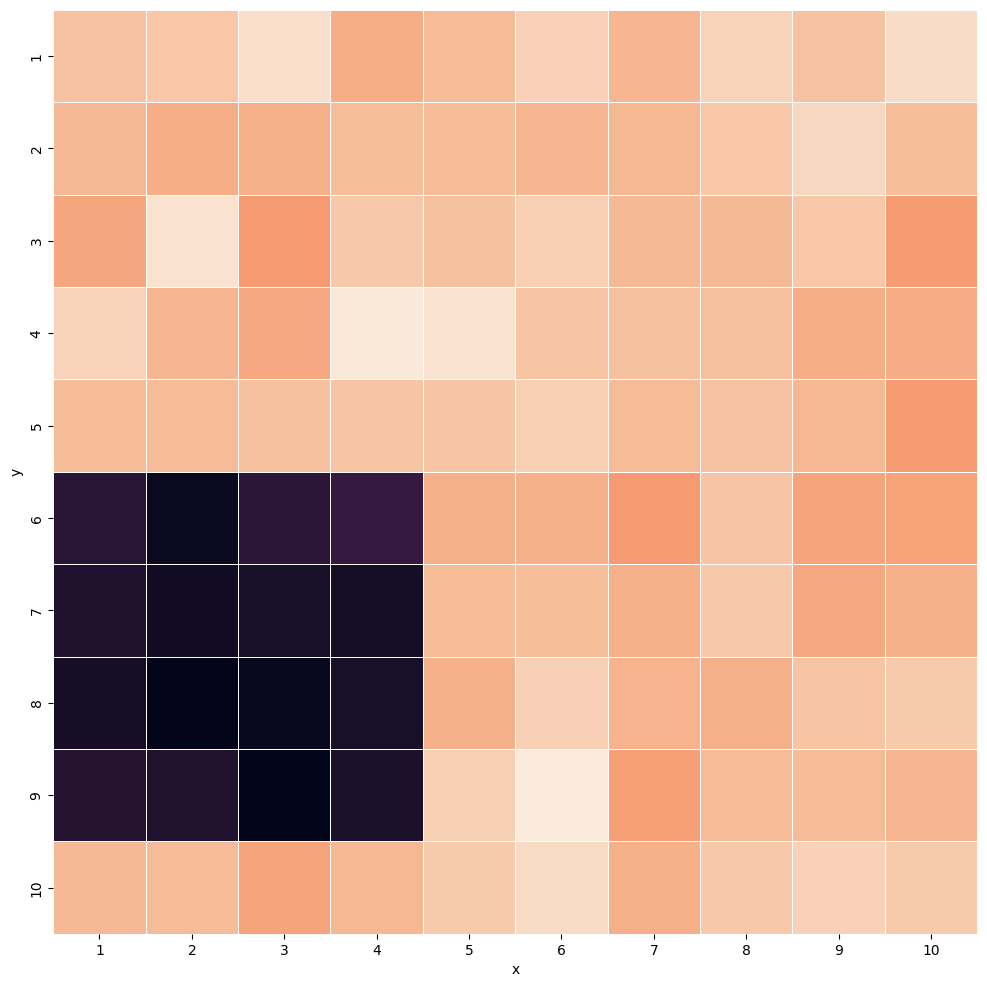

In [74]:
esti_risk = estimated_env_risk_true_mafs.mean(axis=1)
humans['esti_risk'] = esti_risk

# Create subplots for each risk
fig, axs = plt.subplots(1, 1, figsize=(14, 12))
# Aggregate by x and y and calculate mean for each risk
df_agg = humans.groupby(['x', 'y']).agg({'esti_risk': 'mean'}).reset_index()
grid_df = df_agg.pivot(index='y', columns='x', values='esti_risk')
sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)

In [75]:
# Abyss

<Axes: xlabel='x', ylabel='y'>

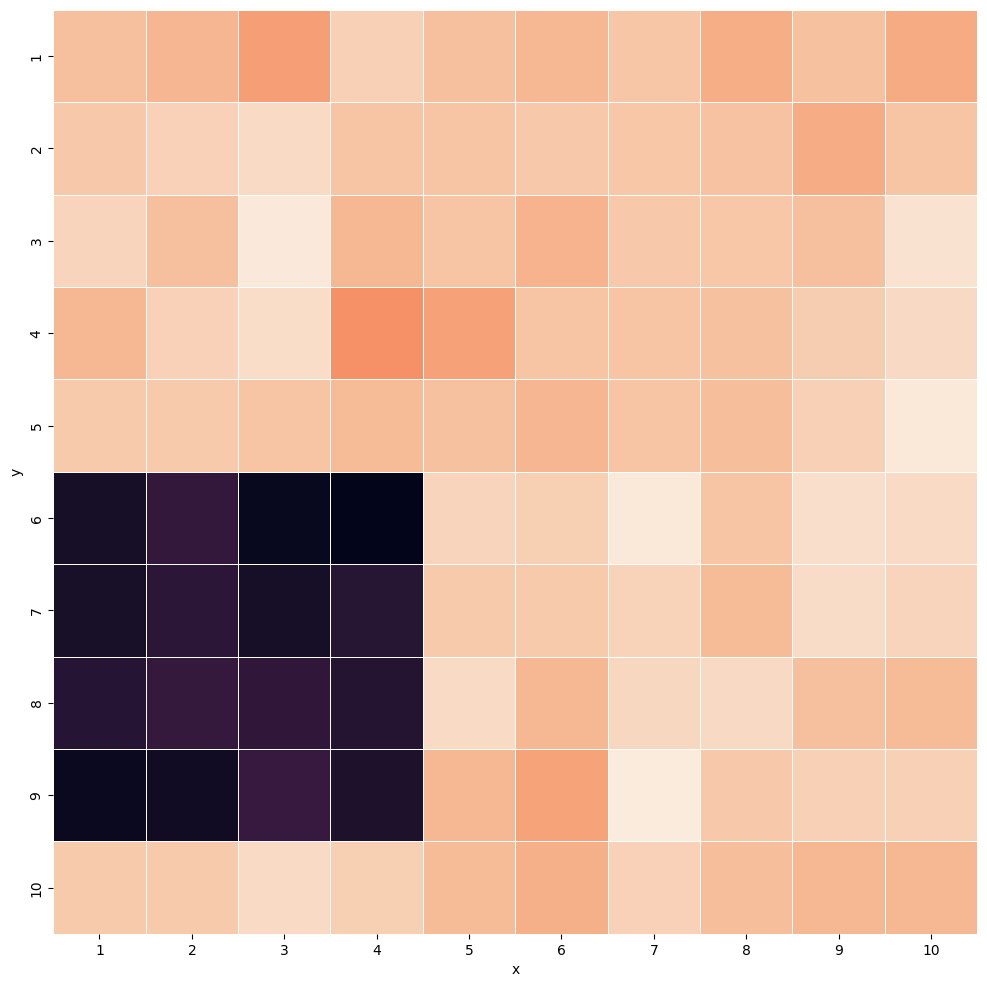

In [76]:
esti_risk = estimated_env_risk_abyss.mean(axis=1)
humans['esti_risk'] = esti_risk

# Create subplots for each risk
fig, axs = plt.subplots(1, 1, figsize=(14, 12))
# Aggregate by x and y and calculate mean for each risk
df_agg = humans.groupby(['x', 'y']).agg({'esti_risk': 'mean'}).reset_index()
grid_df = df_agg.pivot(index='y', columns='x', values='esti_risk')
sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)

In [77]:
# Load abyss bottleneck

In [78]:
path_bottle_file = f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/phenotype/abyss_bottleneck"
bottle_viz_file = [f for f in os.listdir(path_bottle_file) if int(f.split('_')[2]) == 2][0]
bottle_viz = pd.read_pickle(path_bottle_file + "/" + bottle_viz_file)
bottle_file = [f for f in os.listdir(path_bottle_file) if int(f.split('_')[2]) == bottleneck_nr][0]
bottle = pd.read_pickle(path_bottle_file + "/" + bottle_file)

In [79]:
# watch bottle

In [80]:
bottle_viz

,dim1,dim2
0,1.079319,0.528006
1,1.014811,0.574247
2,0.997681,0.444944
3,1.203234,0.434171
4,1.199966,0.458760
...,...,...
1995,0.390613,1.410872
1996,0.605755,1.134764
1997,0.549450,1.406288
1998,0.585023,1.427565


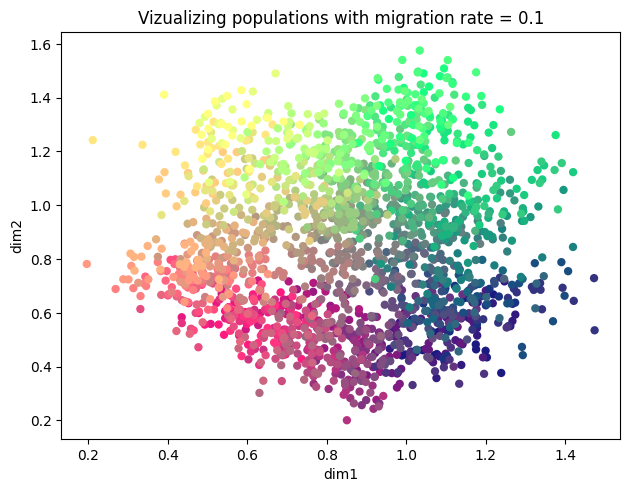

In [81]:
bottle_viz['populations'] = humans['populations']
sns.scatterplot(x='dim1', y='dim2', data=bottle_viz, color=palette, linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing populations with migration rate = {M}")
plt.show()
plt.close()

In [82]:
# humans

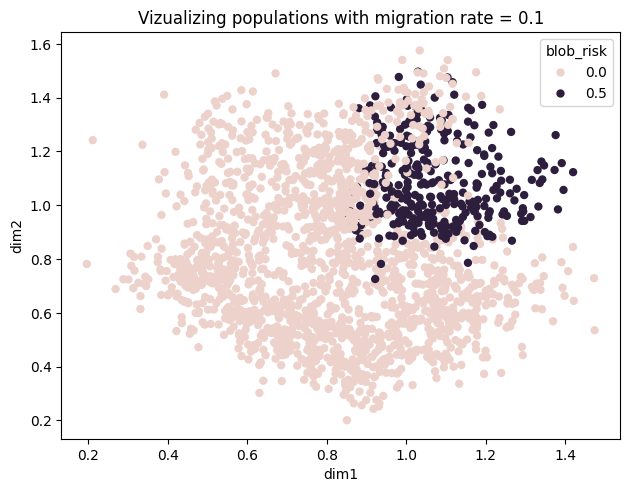

In [83]:
bottle_viz[name_risk] = humans[name_risk]
sns.scatterplot(x='dim1', y='dim2', data=bottle_viz,hue=name_risk, linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing populations with migration rate = {M}")
plt.show()
plt.close()

In [104]:
nr_clusters = 4

In [84]:
bottle['cluster'] = humans['esti_risk']

In [105]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scale all features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(bottle)

# Increase the weight of 'esti_phenotype' by a chosen factor
weight_factor = 1000  # Adjust based on how much influence you want
df_scaled[:, -1] *= weight_factor

# Fit KMeans
kmeans = KMeans(n_clusters=nr_clusters, random_state=0)
kmeans.fit(df_scaled)

KMeans(n_clusters=4, random_state=0)

In [106]:
kmeans.labels_

array([1, 1, 1, ..., 2, 2, 2], dtype=int32)

In [107]:
bottle['cluster'] = kmeans.labels_
bottle_viz['cluster'] = kmeans.labels_

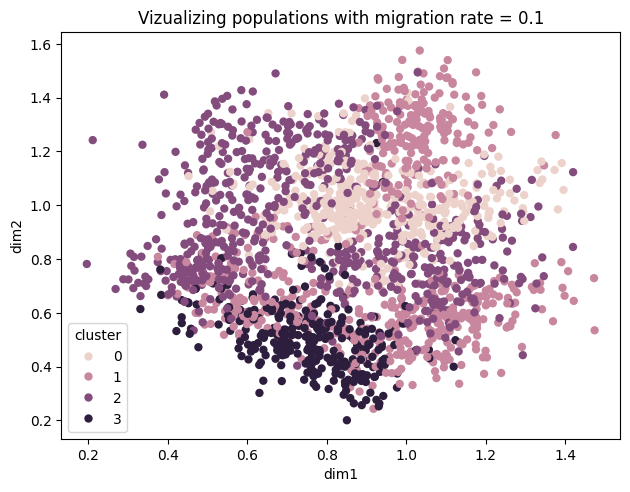

In [108]:
bottle_viz[name_risk] = humans[name_risk]
sns.scatterplot(x='dim1', y='dim2', data=bottle_viz,hue='cluster', linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing populations with migration rate = {M}")
plt.show()
plt.close()

In [109]:
from sklearn.mixture import GaussianMixture

# Apply scaling as above and fit GMM
gmm = GaussianMixture(n_components=nr_clusters, random_state=0)
gmm.fit(df_scaled)


GaussianMixture(n_components=4, random_state=0)

In [110]:
labels = gmm.predict(df_scaled)

In [111]:
labels

array([1, 1, 1, ..., 2, 2, 2])

In [ ]:
bottle['cluster'] = labels
bottle_viz['cluster'] = kmeans.labels_